<a href="https://colab.research.google.com/github/evgeny-kolonsky/IMU/blob/main/airhockey/airtable_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ динамики диска на аэростоле

**Данные:** акселерометр + гироскоп (чип на диске), 50 Гц  
**Установка:** диск на воздушной подушке, по краям стола натянуты струны.


In [132]:
# ============================================================
# ПАРАМЕТРЫ — настроить перед запуском
# ============================================================

URL = 'https://raw.githubusercontent.com/evgeny-kolonsky/IMU/refs/heads/main/airhockey/'
STATIC_FILE = URL + 'static.csv'  # файл со статическими данными (калибровка)
DATA_FILE   = URL + '4.csv'       # файл с динамическими данными

SKIP_FIRST_PEAK = True      # True — первый пик это запуск рукой, не столкновение
                             # False — первый пик это столкновение

COLLISION_THRESHOLD = 0.1    # порог |a_xy| в g для детекции столкновений
COLLISION_MERGE_GAP = 50      # зазор (в отсчётах) для объединения пиков в одно событие
N_AVG = 10                   # число точек для усреднения omega до/после столкновения


In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({
    'figure.figsize': (12, 4), 'figure.dpi': 120,
    'axes.grid': True, 'grid.alpha': 0.3, 'font.size': 10,
})


## 1. Калибровка по статическому измерению

Файл `static.csv` содержит запись неподвижного диска.
Средние значения гироскопа — это дрифт (bias), который вычитается из динамических данных.


In [134]:
stat = np.genfromtxt(STATIC_FILE, delimiter=',', names=True)

gz_bias = np.mean(stat['gz_dps'])
gx_bias = np.mean(stat['gx_dps'])
gy_bias = np.mean(stat['gy_dps'])

gz_std = np.std(stat['gz_dps'])
gx_std = np.std(stat['gx_dps'])
gy_std = np.std(stat['gy_dps'])

print(f"Статическая запись: {len(stat)} отсчётов, {stat['time_s'][-1]:.2f} с")
print(f"")
print(f"Дрифт гироскопа (bias +/- std):")
print(f"  gx = {gx_bias:>7.3f} +/- {gx_std:.3f} °/с")
print(f"  gy = {gy_bias:>7.3f} +/- {gy_std:.3f} °/с")
print(f"  gz = {gz_bias:>7.3f} +/- {gz_std:.3f} °/с")


Статическая запись: 250 отсчётов, 4.98 с

Дрифт гироскопа (bias +/- std):
  gx =   1.292 +/- 0.050 °/с
  gy =  -2.904 +/- 0.056 °/с
  gz =   0.384 +/- 0.064 °/с


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-3079983768.py:2: SyntaxWarning: invalid escape sequence '\o'
  ax.plot(stat['time_s'], stat['gz_dps'], lw=0.6, label='$\omega_z$ raw')
/tmp/ipython-input-3079983768.py:7: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title('Статическое измерение $\omega_z$'); ax.legend()


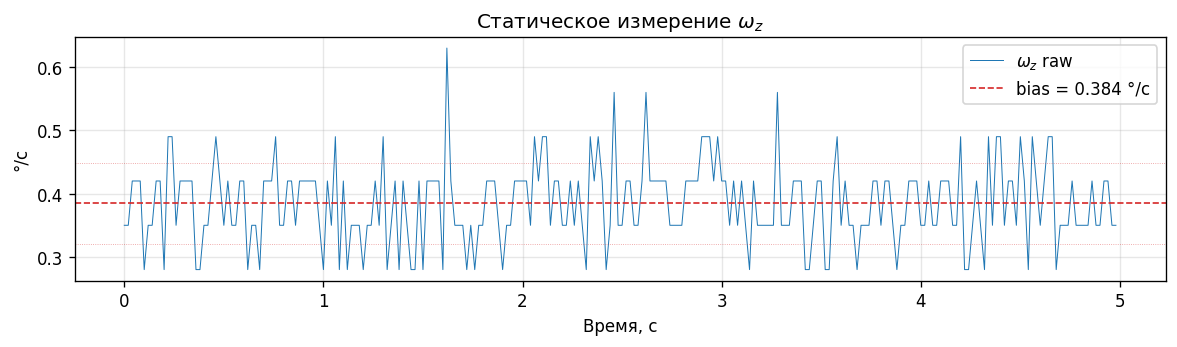

In [135]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(stat['time_s'], stat['gz_dps'], lw=0.6, label='$\omega_z$ raw')
ax.axhline(gz_bias, color='C3', ls='--', lw=1, label=f'bias = {gz_bias:.3f} °/с')
ax.axhline(gz_bias + gz_std, color='C3', ls=':', lw=0.5, alpha=0.5)
ax.axhline(gz_bias - gz_std, color='C3', ls=':', lw=0.5, alpha=0.5)
ax.set_xlabel('Время, с'); ax.set_ylabel('°/с')
ax.set_title('Статическое измерение $\omega_z$'); ax.legend()
plt.tight_layout(); plt.show()


## 2. Загрузка динамических данных

In [136]:
data = np.genfromtxt(DATA_FILE, delimiter=',', names=True)
t     = data['time_s']
ax_g  = data['ax_g']
ay_g  = data['ay_g']
az_g  = data['az_g']
gx    = data['gx_dps'] - gx_bias
gy    = data['gy_dps'] - gy_bias
gz    = data['gz_dps'] - gz_bias   # калиброванная угловая скорость

dt = np.median(np.diff(t))
print(f"Отсчётов: {len(t)},  dt = {dt:.3f} с ({1/dt:.0f} Гц)")
print(f"Длительность: {t[-1]:.1f} с")
print(f"Дрифт gz вычтен: {gz_bias:.3f} °/с")


Отсчётов: 1000,  dt = 0.020 с (50 Гц)
Длительность: 20.0 с
Дрифт gz вычтен: 0.384 °/с


## 3. Обзорные графики

<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:13: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1702922894.py:13: SyntaxWarning: invalid escape sequence '\o'
  axes[2].set_title('$\omega_z$ (после калибровки)'); axes[2].axhline(0, color='gray', lw=0.5)


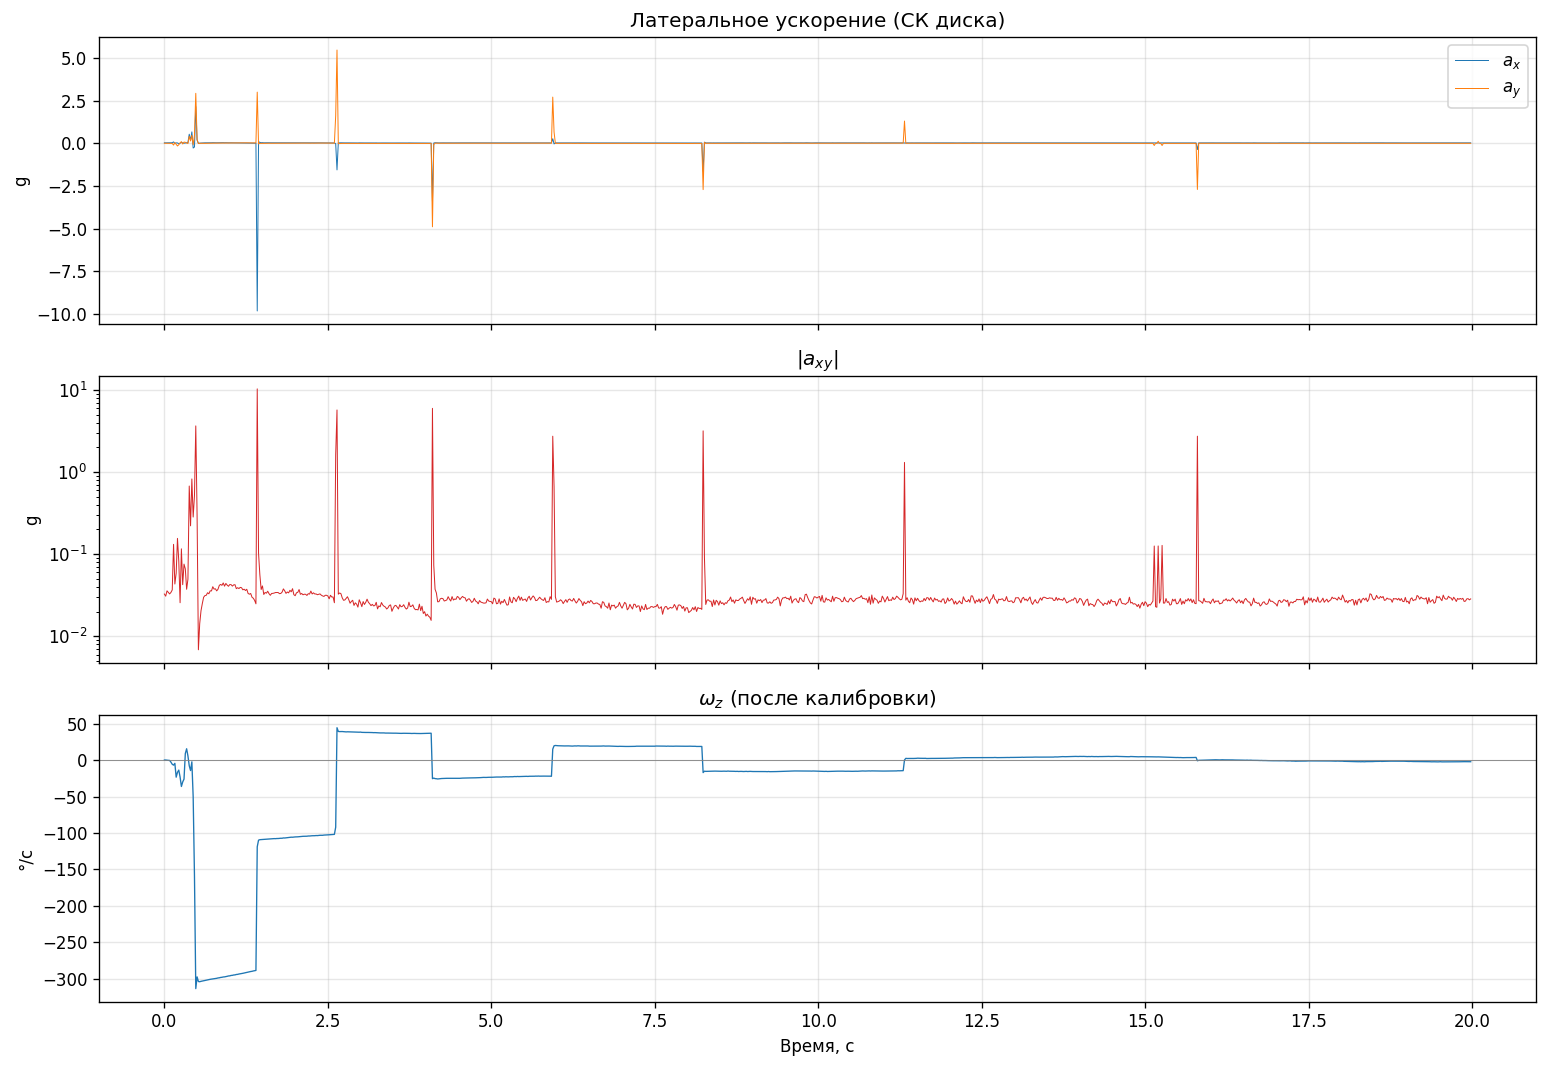

In [137]:
a_xy = np.sqrt(ax_g**2 + ay_g**2)

fig, axes = plt.subplots(3, 1, figsize=(13, 9), sharex=True)
axes[0].plot(t, ax_g, lw=0.6, label='$a_x$')
axes[0].plot(t, ay_g, lw=0.6, label='$a_y$')
axes[0].set_ylabel('g'); axes[0].set_title('Латеральное ускорение (СК диска)'); axes[0].legend()

axes[1].plot(t, a_xy, lw=0.6, color='C3')
axes[1].set_ylabel('g'); axes[1].set_title('$|a_{xy}|$'); axes[1].set_yscale('log')

axes[2].plot(t, gz, lw=0.8, color='C0')
axes[2].set_ylabel('°/с'); axes[2].set_xlabel('Время, с')
axes[2].set_title('$\omega_z$ (после калибровки)'); axes[2].axhline(0, color='gray', lw=0.5)
plt.tight_layout(); plt.show()


## 4. Детекция столкновений

In [138]:
def detect_collisions(a_xy, threshold, merge_gap):
    indices = np.where(a_xy > threshold)[0]
    if len(indices) == 0:
        return []
    groups = [[indices[0]]]
    for i in range(1, len(indices)):
        if indices[i] - indices[i-1] <= merge_gap:
            groups[-1].append(indices[i])
        else:
            groups.append([indices[i]])
    return [np.array(g) for g in groups]

all_events = detect_collisions(a_xy, COLLISION_THRESHOLD, COLLISION_MERGE_GAP)
print(f"Обнаружено событий: {len(all_events)}")

if SKIP_FIRST_PEAK and len(all_events) > 0:
    launch_event = all_events[0]
    collisions = all_events[1:]
    print(f"  Первый пик (t ~ {t[launch_event[0]]:.2f} с) исключён (SKIP_FIRST_PEAK=True)")
else:
    launch_event = None
    collisions = all_events

print(f"  Столкновений для анализа: {len(collisions)}")


Обнаружено событий: 7
  Первый пик (t ~ 0.14 с) исключён (SKIP_FIRST_PEAK=True)
  Столкновений для анализа: 6


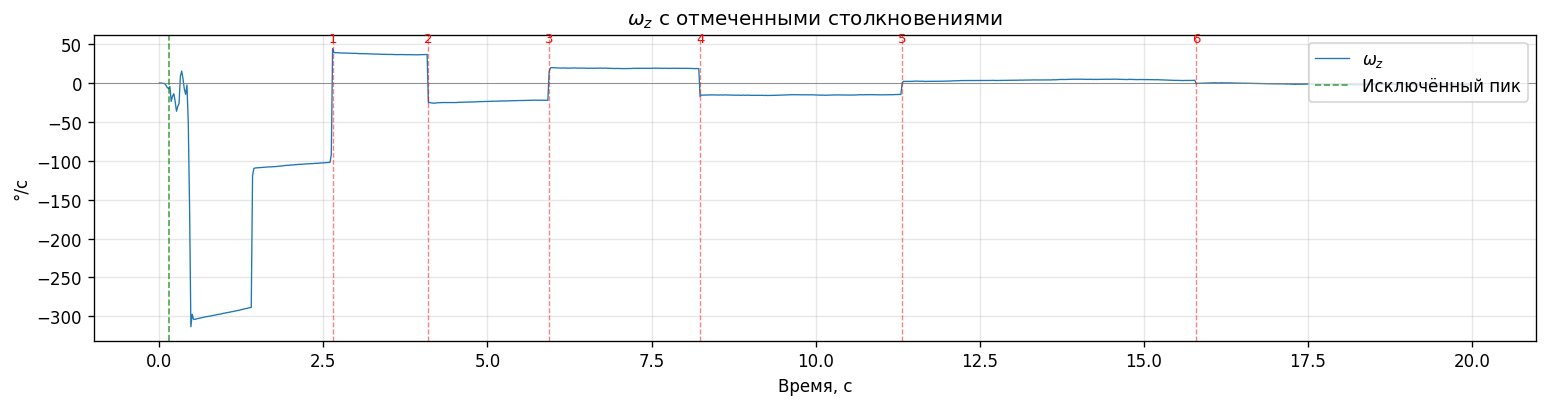

In [139]:
fig, ax = plt.subplots(figsize=(13, 3.5))
ax.plot(t, gz, lw=0.8, color='C0', label=r'$\omega_z$')
ax.axhline(0, color='gray', lw=0.5)

if launch_event is not None:
    ax.axvline(t[launch_event[0]], color='green', ls='--', lw=1, alpha=0.7, label='Исключённый пик')

for i, grp in enumerate(collisions):
    pk = grp[np.argmax(a_xy[grp])]
    ax.axvline(t[pk], color='red', ls='--', lw=0.8, alpha=0.5)
    ax.text(t[pk], ax.get_ylim()[1]*0.85, f'{i+1}', ha='center', fontsize=8, color='red')

ax.set_xlabel('Время, с'); ax.set_ylabel('°/с')
ax.set_title(r'$\omega_z$ с отмеченными столкновениями'); ax.legend(loc='upper right')
plt.tight_layout(); plt.show()


## 5. Пересчёт ускорений в лабораторную систему координат

Акселерометр измеряет в **подвижной СК диска**. Интегрируем калиброванную $\omega_z$
для получения угла поворота $\theta(t)$ и поворачиваем вектор ускорения:

$$a_x^{\text{lab}} = a_x \cos\theta - a_y \sin\theta, \qquad a_y^{\text{lab}} = a_x \sin\theta + a_y \cos\theta$$


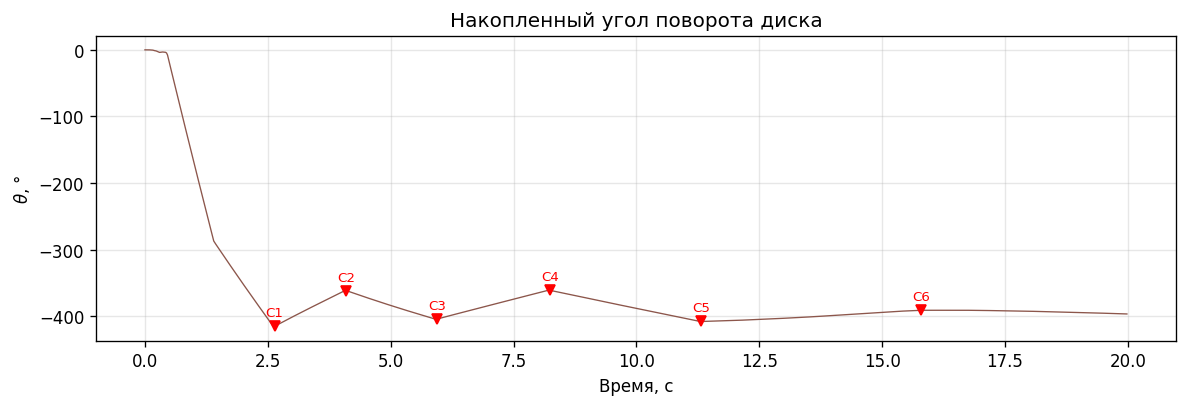

In [140]:
theta_deg = np.cumsum(gz * dt)
theta_rad = np.radians(theta_deg)

ax_lab = ax_g * np.cos(theta_rad) - ay_g * np.sin(theta_rad)
ay_lab = ax_g * np.sin(theta_rad) + ay_g * np.cos(theta_rad)

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(t, theta_deg, lw=0.8, color='C5')
for i, grp in enumerate(collisions):
    pk = grp[np.argmax(a_xy[grp])]
    ax.plot(t[pk], theta_deg[pk], 'rv', ms=6)
    ax.text(t[pk], theta_deg[pk]+15, f'C{i+1}', ha='center', fontsize=8, color='red')
ax.set_xlabel('Время, с'); ax.set_ylabel(r'$\theta$, °')
ax.set_title('Накопленный угол поворота диска'); plt.tight_layout(); plt.show()


## 6. Параметры столкновений

In [141]:
records = []
for i, grp in enumerate(collisions):
    pk = grp[np.argmax(a_xy[grp])]
    peak_a = a_xy[pk]
    theta_body = np.degrees(np.arctan2(ay_g[pk], ax_g[pk]))
    theta_lab  = np.degrees(np.arctan2(ay_lab[pk], ax_lab[pk]))

    b_s, b_e = max(0, grp[0] - N_AVG), grp[0]
    a_s, a_e = grp[-1] + 1, min(len(t), grp[-1] + 1 + N_AVG)

    w_before = np.mean(gz[b_s:b_e]) if b_e > b_s else np.nan
    w_after  = np.mean(gz[a_s:a_e]) if a_e > a_s else np.nan
    dw = w_after - w_before
    sign_flip = np.sign(w_before) != np.sign(w_after)
    ke_ratio = (w_after / w_before)**2 if abs(w_before) > 0.5 else np.nan

    records.append((i+1, t[pk], peak_a, theta_body, theta_lab,
                    w_before, w_after, dw, sign_flip, ke_ratio))

names = ['#', 't', '|a|_g', 'th_body', 'th_lab', 'w_bef', 'w_aft', 'dw', 'flip', 'KE_r']
header = '{:>3} {:>7} {:>7} {:>8} {:>8} {:>8} {:>8} {:>8} {:>5} {:>7}'.format(*names)
print(header)
print('-' * len(header))
for r in records:
    ke_str = f'{r[9]:.3f}' if not np.isnan(r[9]) else '    —'
    print('{:>3} {:>7.3f} {:>7.2f} {:>8.1f} {:>8.1f} {:>8.1f} {:>8.1f} {:>8.1f} {:>5} {:>7}'.format(
        r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7], 'da' if r[8] else '', ke_str))


  #       t   |a|_g  th_body   th_lab    w_bef    w_aft       dw  flip    KE_r
------------------------------------------------------------------------------
  1   2.640    5.69    105.9     51.2   -102.5     38.9    141.4    da   0.144
  2   4.100    5.95   -124.7   -126.1     36.6    -25.4    -61.9    da   0.482
  3   5.940    2.72     84.3     40.3    -22.0     19.6     41.6    da   0.788
  4   8.240    3.17   -121.1   -121.9     18.8    -15.3    -34.0    da   0.659
  5  11.320    1.31     89.1     41.6    -14.8      2.3     17.0    da   0.023
  6  15.800    2.73    -97.6   -128.4      4.5     -0.0     -4.5    da   0.000


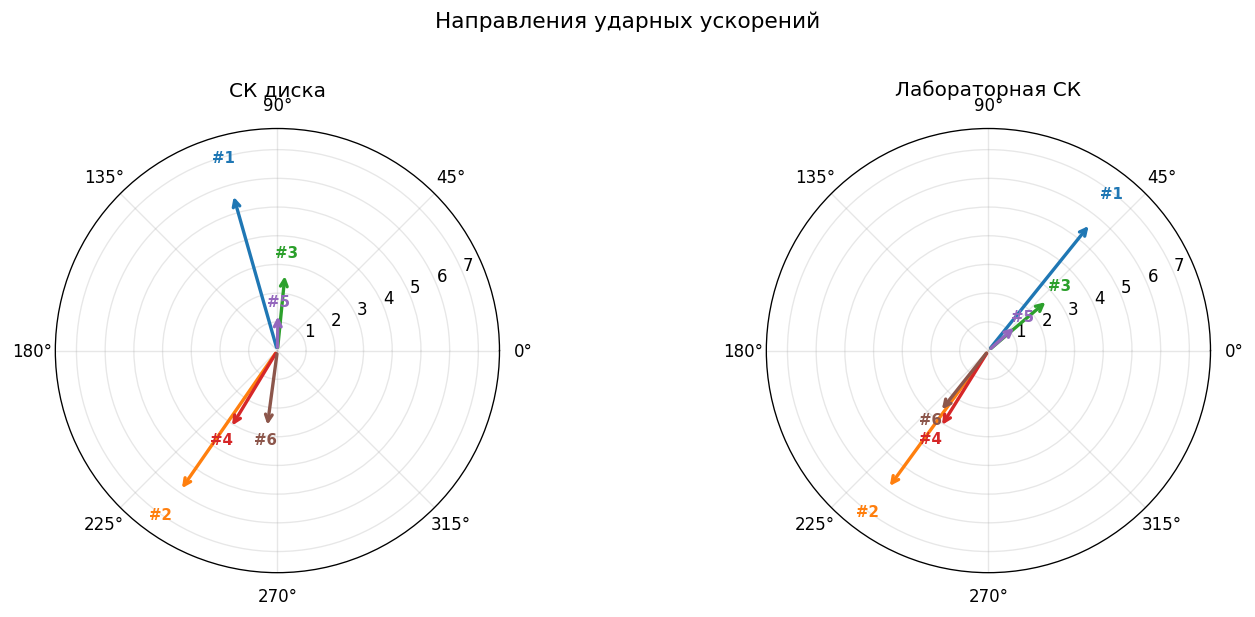

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': 'polar'})
rmax = max(a_xy[grp[np.argmax(a_xy[grp])]] for grp in collisions) * 1.3

for ax_p, frame, title in [(axes[0], 'body', 'СК диска'),
                            (axes[1], 'lab', 'Лабораторная СК')]:
    for i, grp in enumerate(collisions):
        pk = grp[np.argmax(a_xy[grp])]
        if frame == 'body':
            axp, ayp = ax_g[pk], ay_g[pk]
        else:
            axp, ayp = ax_lab[pk], ay_lab[pk]
        a_mag = np.sqrt(axp**2 + ayp**2)
        th = np.arctan2(ayp, axp)
        ax_p.annotate('', xy=(th, a_mag), xytext=(0, 0),
                      arrowprops=dict(arrowstyle='->', color=f'C{i}', lw=2))
        ax_p.text(th, a_mag*1.2, f'#{i+1}', ha='center', fontsize=9,
                  fontweight='bold', color=f'C{i}')
    ax_p.set_title(title, pad=20); ax_p.set_rmax(rmax)

plt.suptitle('Направления ударных ускорений', fontsize=13, y=1.02)
plt.tight_layout(); plt.show()


## 7. Модель вращательного трения

На тихих сегментах между столкновениями измеряем $|\alpha|$ и $|\omega|$
через линейную аппроксимацию $\omega(t)$.


In [143]:
def get_quiet_segments(n, launch_event, collisions, margin=5, min_len=15):
    segments = []
    first_start = (launch_event[-1] if launch_event is not None else 0) + margin
    first_end = collisions[0][0] - margin if len(collisions) > 0 else n - 1
    if first_end - first_start >= min_len:
        segments.append((first_start, first_end))
    for i in range(len(collisions)):
        start = collisions[i][-1] + margin
        end = collisions[i+1][0] - margin if i < len(collisions)-1 else n - 1
        if end - start >= min_len:
            segments.append((start, end))
    return segments

segments = get_quiet_segments(len(t), launch_event, collisions)

omega_pts, alpha_pts = [], []
print(f"{'Сегмент':>8}  {'t':>14}  {'<w>, °/с':>10}  {'alpha, °/с²':>12}")
print('-' * 50)
for idx, (s, e) in enumerate(segments):
    ts, ws = t[s:e+1], gz[s:e+1]
    slope = np.polyfit(ts, ws, 1)[0]
    w_mean = np.mean(ws)
    print(f"  {idx:>5}   {ts[0]:>5.2f}-{ts[-1]:.2f}  {w_mean:>10.1f}  {slope:>11.2f}")
    if abs(w_mean) > 3:
        omega_pts.append(abs(w_mean))
        alpha_pts.append(abs(slope))

omega_pts = np.array(omega_pts)
alpha_pts = np.array(alpha_pts)


 Сегмент               t    <w>, °/с   alpha, °/с²
--------------------------------------------------
      0    1.54-2.52      -105.4         6.49
      1    2.74-4.00        37.3        -2.07
      2    4.20-5.84       -23.6         2.31
      3    6.06-8.14        19.1        -0.21
      4    8.34-11.22       -15.3         0.17
      5   11.42-15.04         3.8         0.83
      6   15.90-19.98        -1.3        -0.67


|alpha| = 0.06173 * |omega| + (-0.088)
  tau = 16.2 с


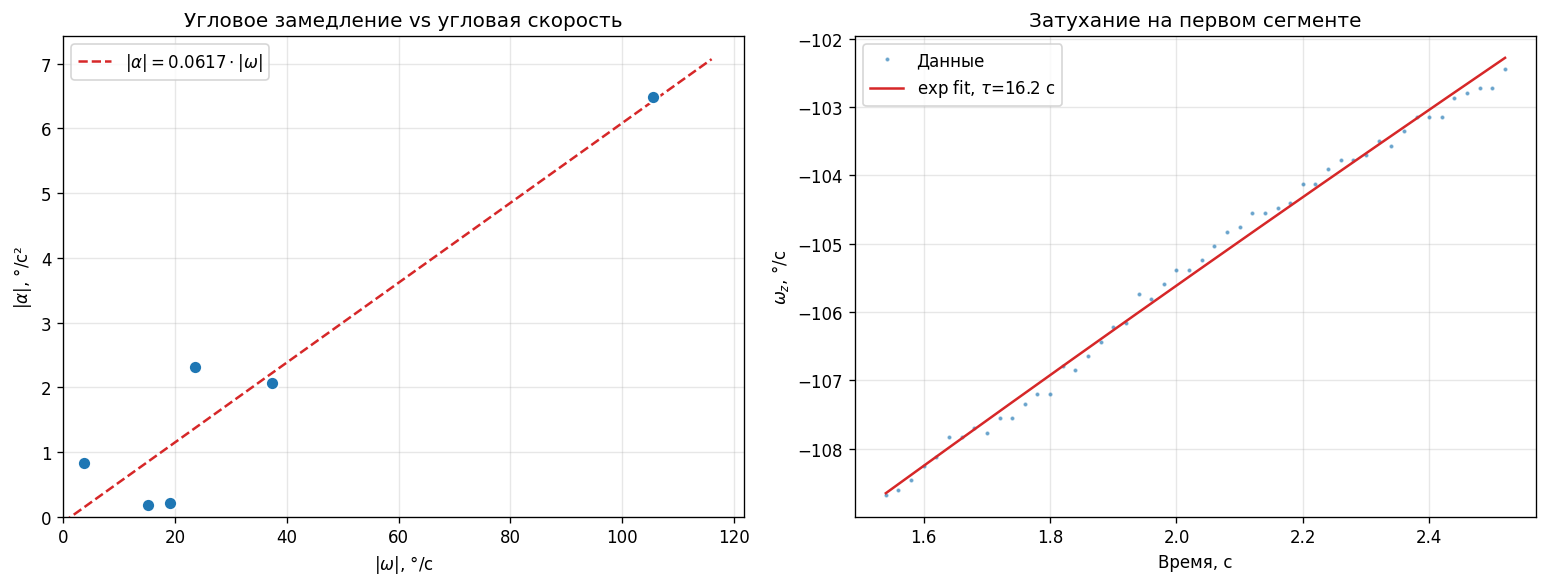

In [144]:
if len(omega_pts) >= 2:
    k_visc, k_coul = np.polyfit(omega_pts, alpha_pts, 1)
    tau = 1.0 / k_visc if k_visc > 0 else np.inf
    print(f"|alpha| = {k_visc:.5f} * |omega| + ({k_coul:.3f})")
    print(f"  tau = {1/k_visc:.1f} с")
else:
    k_visc, k_coul, tau = np.nan, np.nan, np.nan
    print("Недостаточно данных для фита")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(omega_pts, alpha_pts, s=60, zorder=5, color='C0', edgecolors='white')
if len(omega_pts) >= 2:
    wf = np.linspace(0, omega_pts.max()*1.1, 100)
    ax.plot(wf, k_visc*wf + k_coul, 'C3--', lw=1.5, label=r'$|\alpha|=%.4f\cdot|\omega|$' % k_visc)
ax.set_xlabel(r'$|\omega|$, °/с'); ax.set_ylabel(r'$|\alpha|$, °/с²')
ax.set_title('Угловое замедление vs угловая скорость')
ax.set_xlim(0); ax.set_ylim(0); ax.legend()

ax = axes[1]
s, e = segments[0]
ts_seg, ws_seg = t[s:e+1], gz[s:e+1]
def exp_decay(tt, w0, tau_f, t0): return w0 * np.exp(-(tt - t0) / tau_f)
try:
    p0_tau = tau if not np.isnan(tau) else 15.0
    popt, _ = curve_fit(exp_decay, ts_seg, ws_seg, p0=[ws_seg[0], p0_tau, ts_seg[0]], maxfev=5000)
    tf = np.linspace(ts_seg[0], ts_seg[-1], 200)
    ax.plot(ts_seg, ws_seg, '.', ms=3, alpha=0.5, label='Данные')
    ax.plot(tf, exp_decay(tf, *popt), 'C3-', lw=1.5, label=r'exp fit, $\tau$=%.1f с' % popt[1])
except Exception:
    ax.plot(ts_seg, ws_seg, '.', ms=3, alpha=0.5, label='Данные')
ax.set_xlabel('Время, с'); ax.set_ylabel(r'$\omega_z$, °/с')
ax.set_title('Затухание на первом сегменте'); ax.legend()
plt.tight_layout(); plt.show()


## 8. Тангенциальный импульс при столкновении

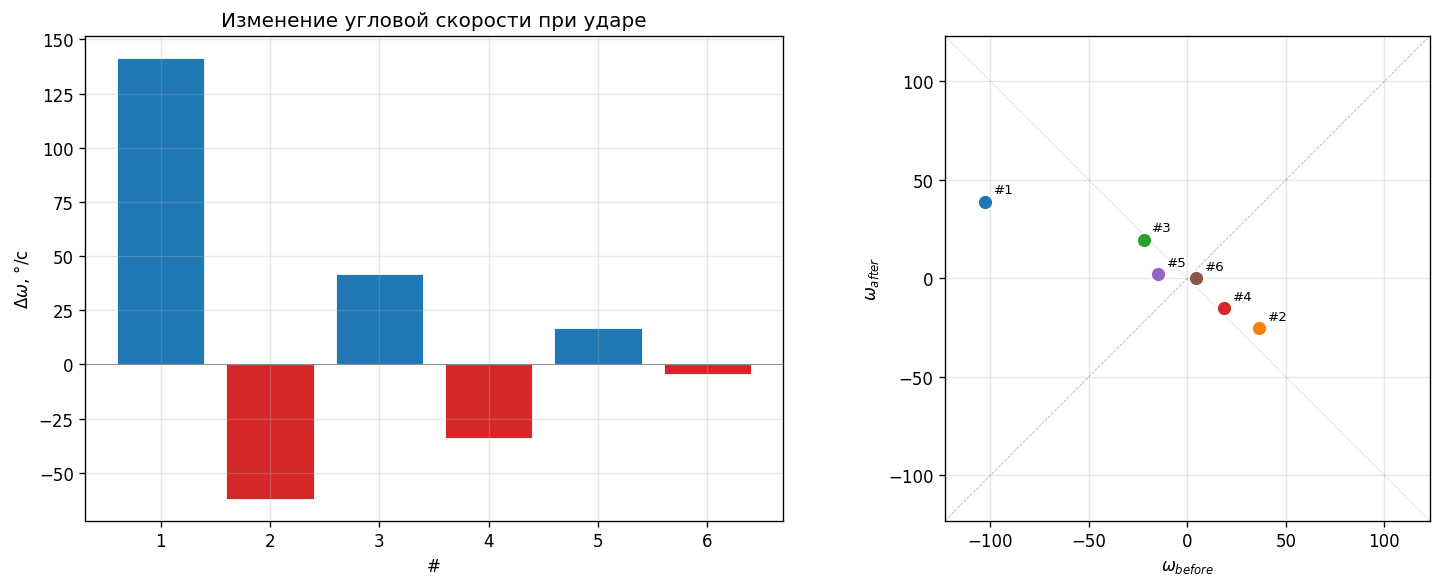

In [145]:
w_before = np.array([r[5] for r in records])
w_after  = np.array([r[6] for r in records])
dw = w_after - w_before
x = np.arange(1, len(collisions)+1)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.bar(x, dw, color=['C0' if d>0 else 'C3' for d in dw], edgecolor='white', lw=0.5)
ax.set_xlabel('#'); ax.set_ylabel(r'$\Delta\omega$, °/с')
ax.set_title('Изменение угловой скорости при ударе')
ax.axhline(0, color='gray', lw=0.5); ax.set_xticks(x)

ax = axes[1]
for i in range(len(collisions)):
    ax.scatter(w_before[i], w_after[i], s=80, zorder=5, c=f'C{i}', edgecolors='white')
    ax.annotate(f'#{i+1}', (w_before[i], w_after[i]), fontsize=8, xytext=(5,5), textcoords='offset points')
lim = max(np.max(np.abs(w_before)), np.max(np.abs(w_after))) * 1.2
ax.plot([-lim,lim],[-lim,lim], 'k--', lw=0.5, alpha=0.3)
ax.plot([-lim,lim],[lim,-lim], 'k:', lw=0.5, alpha=0.3)
ax.set_xlabel(r'$\omega_{before}$'); ax.set_ylabel(r'$\omega_{after}$')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_aspect('equal')
plt.tight_layout(); plt.show()


## 9. Замедление поступательного движения

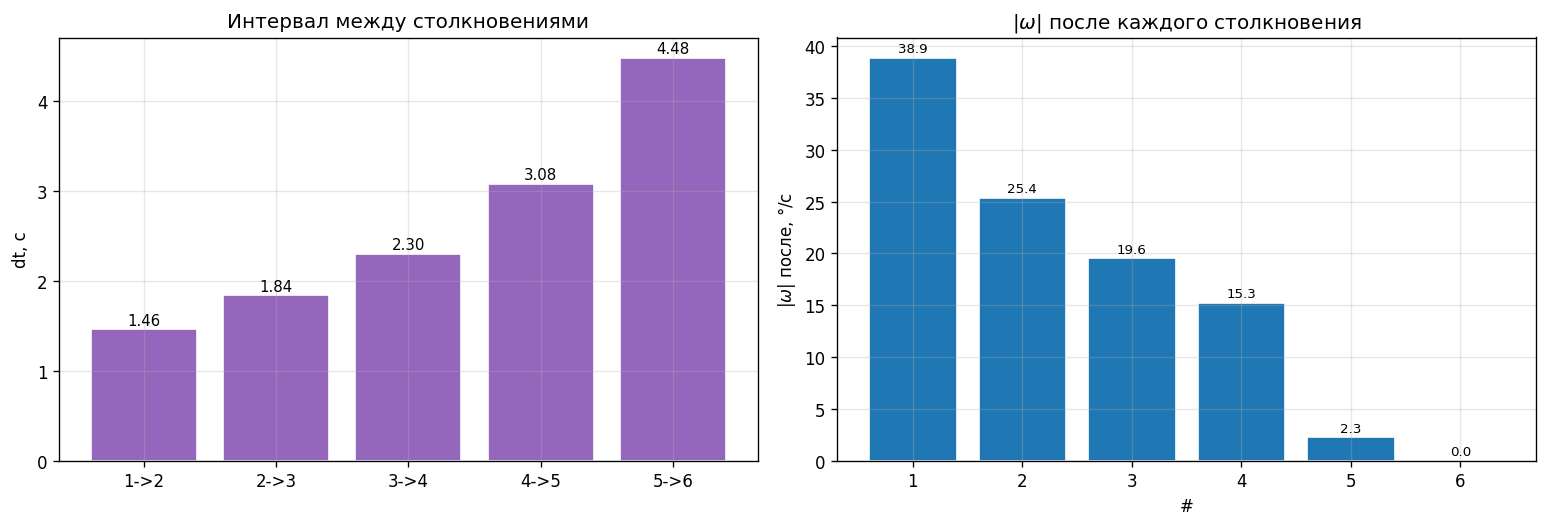

In [146]:
ct = np.array([t[grp[np.argmax(a_xy[grp])]] for grp in collisions])
dt_between = np.diff(ct)
w_after_abs = np.abs(w_after)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

ax = axes[0]
lbls = [f'{i+1}->{i+2}' for i in range(len(dt_between))]
ax.bar(lbls, dt_between, color='C4', edgecolor='white')
ax.set_ylabel('dt, с'); ax.set_title('Интервал между столкновениями')
for i, v in enumerate(dt_between): ax.text(i, v+0.05, f'{v:.2f}', ha='center', fontsize=9)

ax = axes[1]
ax.bar(x, w_after_abs, color='C0', edgecolor='white')
ax.set_xlabel('#'); ax.set_ylabel(r'$|\omega|$ после, °/с')
ax.set_title(r'$|\omega|$ после каждого столкновения')
for i, v in enumerate(w_after_abs): ax.text(i+1, v+0.5, f'{v:.1f}', ha='center', fontsize=8)
plt.tight_layout(); plt.show()
